### PART 1: Import datacube

In [3]:
# importing module
import os
import sys
import numpy as np
import py4DSTEM
from py4DSTEM import show
import h5py
import matplotlib.pyplot as plt
import hyperspy.api as hs
from typing import Callable, Dict, Any, Optional
from abc import ABC, abstractmethod
import torch

In [49]:
#%run Beam_centering.ipynb

In [19]:
#%run Memory_efficient_centering.ipynb

In [193]:
%run low_dose_noise_models.ipynb 

In [4]:
#check that GPU is available
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_capability(0))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

True
1
0
NVIDIA RTX 6000 Ada Generation
(8, 9)
Device:  cuda


In [3]:
#%matplotlib widget 

In [161]:
directory_path = r"C:\Users\cancellara\0_Hackaton2025\Leeds Molecular crystals"
filepath_index = 24

filepaths = {
    #Wax
    '0': directory_path + r"\4D-STEM_data_for_wax\20210722_212158_data._binned2.hdf5",
    '1': directory_path + r"\4D-STEM_data_for_wax\20210722_221445_data._binned2.hdf5",
    
    #Anthracene
    '2': directory_path + r"\4D-STEM_data_for_anthracene\Mg30157\20220509_182024_data_binned2.hdf5",
    '3': directory_path + r"\4D-STEM_data_for_anthracene\Mg30157\20220509_182412_data_binned2.hdf5",
    '4': directory_path + r"\4D-STEM_data_for_anthracene\Mg30157\20220509_183737_data_binned2.hdf5",
    '5': directory_path + r"\4D-STEM_data_for_anthracene\Mg30157\20220509_194940_data_binned2.hdf5",
    '6': directory_path + r"\4D-STEM_data_for_anthracene\Mg31872\20221020_211713_data_binned2.hdf5",
    
    #Theophylline
    '7': directory_path + r"\4D-STEM data for theophylline\20210723_115610_data_binned2.hdf5",
    '8': directory_path + r"\4D-STEM data for theophylline\20220711_182642_data_150kX_binned2.hdf5",
    '9': directory_path + r"\4D-STEM data for theophylline\20220711_183034_data_100kX._binned2.hdf5",
    '10': directory_path + r"\4D-STEM data for theophylline\20220711_190318_data_100kX._binned2.hdf5",
    '11': directory_path + r"\4D-STEM data for theophylline\20220712_112000_data_100kX._binned2.hdf5",
    
    #P-terphenyl
    '12': directory_path + r"\4D-STEM data for p-terphenyl\Mg30157\20220510_093618_data_binned2.hdf5",
    '13': directory_path + r"\4D-STEM data for p-terphenyl\Mg30157\20220510_093908_data_binned2.hdf5",
    '14': directory_path + r"\4D-STEM data for p-terphenyl\Mg30157\20220510_095534_data_binned2.hdf5",
    '15': directory_path + r"\4D-STEM data for p-terphenyl\Mg30160\20220904_104733_data_binned2.hdf5",
    '16': directory_path + r"\4D-STEM data for p-terphenyl\Mg30160\20220904_105044_data_binned2.hdf5",
    '17': directory_path + r"\4D-STEM data for p-terphenyl\Mg31258\20220322_181944_data_binned2.hdf5",
    '18': directory_path + r"\4D-STEM data for p-terphenyl\Mg31258\20220322_182433_data_binned2.hdf5",
    '19': directory_path + r"\4D-STEM data for p-terphenyl\Mg31258\20220322_182645_data_binned2.hdf5",
    '20': directory_path + r"\4D-STEM data for p-terphenyl\Mg31258\20220323_160424_data_binned2.hdf5",

    #Noisy
    '21': directory_path + r"\Noisy_datacubes\p-terphenyl_20_low_dose.hdf5",
    '22': directory_path + r"\Noisy_datacubes\p-terphenyl_20_light-noise.hdf5",
    '23': directory_path + r"\Noisy_datacubes\p-terphenyl_20_medium-noise.hdf5",
    '24': directory_path + r"\Noisy_datacubes\p-terphenyl_20_heavy-noise.hdf5",
    
}

py4DSTEM.print_h5_tree(filepaths[str(filepath_index)])

/
|---Experiments
    |---__unnamed__
        |---attributes
        |---axis-0
        |---axis-1
        |---axis-2
        |---axis-3
        |---learning_results
        |---metadata
        |   |---General
        |   |   |---FileIO
        |   |       |---0
        |   |---Signal
        |   |---_HyperSpy
        |       |---Folding
        |---original_metadata




In [162]:
s = hs.load(filepaths[str(filepath_index)], reader='HSPY')

In [163]:
test_mean = np.mean(s.inav[:,:].data, axis=(0,1))
test_max = np.max(s.inav[:,:].data, axis=(0,1))

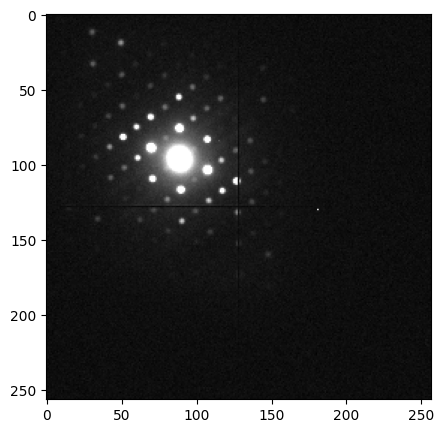

In [173]:
plt.figure(figsize=(5,5))
plt.imshow(test_mean) #, vmax=2, cmap='gray')

In [67]:
# it'd best if we could move between hyperspy and py4dstem.
# the simplest way is to transfer the data to a new class instance, but careful with array dimensions and metadata
# if necessary we can write a function to smoothly move data and metadata
# PRIORITY : LOW

datacube = py4DSTEM.DataCube(s.data) 

### PART 2: Add noise (only to create data, not needed for testing)

In [69]:
# ============================================================================
# Abstract base class for noise models
# ============================================================================
class NoiseModel(ABC):
    """Base class for noise models"""
    
    @abstractmethod
    def apply(self, data: np.ndarray, **kwargs) -> np.ndarray:
        """
        Apply noise to the data
        
        Parameters
        ----------
        data : np.ndarray
            Input data array
        **kwargs : additional parameters for the noise model
        
        Returns
        -------
        np.ndarray
            Data with noise added
        """
        pass

# ============================================================================
# Concrete noise model implementations. More models can be added if necessary.
# ============================================================================
class PoissonNoise(NoiseModel):
    """Shot noise following Poisson statistics"""
    
    def apply(self, data: np.ndarray, scale: float = 1.0) -> np.ndarray:
        """
        Apply Poisson noise
        
        Parameters
        ----------
        data : np.ndarray
            Input data (should be non-negative)
        scale : float
            Scaling factor for intensity before applying Poisson
        
        Returns
        -------
        np.ndarray
            Data with Poisson noise
        """
        # Scale data, apply Poisson, scale back
        scaled = data * scale
        noisy = np.random.poisson(scaled)
        return noisy / scale


class GaussianNoise(NoiseModel):
    """Additive Gaussian (normal) noise"""
    
    def apply(self, data: np.ndarray, mean: float = 0.0, 
              sigma: float = 1.0) -> np.ndarray:
        """
        Apply Gaussian noise
        
        Parameters
        ----------
        data : np.ndarray
            Input data
        mean : float
            Mean of Gaussian distribution
        sigma : float
            Standard deviation of Gaussian distribution
        
        Returns
        -------
        np.ndarray
            Data with Gaussian noise added
        """
        noise = np.random.normal(mean, sigma, data.shape)
        return data + noise


class ReadoutNoise(NoiseModel):
    """Detector readout noise (Gaussian)"""
    
    def apply(self, data: np.ndarray, sigma: float = 5.0) -> np.ndarray:
        """
        Apply readout noise
        
        Parameters
        ----------
        data : np.ndarray
            Input data
        sigma : float
            Standard deviation of readout noise in counts
        
        Returns
        -------
        np.ndarray
            Data with readout noise added
        """
        noise = np.random.normal(0, sigma, data.shape)
        return data + noise


class DarkCurrentNoise(NoiseModel):
    """Dark current noise (Poisson-distributed)"""
    
    def apply(self, data: np.ndarray, dark_current: float = 1.0) -> np.ndarray:
        """
        Apply dark current noise
        
        Parameters
        ----------
        data : np.ndarray
            Input data
        dark_current : float
            Mean dark current in counts per pixel
        
        Returns
        -------
        np.ndarray
            Data with dark current noise added
        """
        dark = np.random.poisson(dark_current, data.shape)
        return data + dark


class SaltPepperNoise(NoiseModel):
    """Salt and pepper (impulse) noise"""
    
    def apply(self, data: np.ndarray, probability: float = 0.01,
              salt_value: Optional[float] = None,
              pepper_value: float = 0.0) -> np.ndarray:
        """
        Apply salt and pepper noise
        
        Parameters
        ----------
        data : np.ndarray
            Input data
        probability : float
            Probability of a pixel being affected (total for both salt and pepper)
        salt_value : float, optional
            Value for 'salt' pixels. If None, uses max of data
        pepper_value : float
            Value for 'pepper' pixels
        
        Returns
        -------
        np.ndarray
            Data with salt and pepper noise
        """
        noisy = data.copy()
        
        if salt_value is None:
            salt_value = np.max(data)
        
        # Salt noise
        salt_mask = np.random.random(data.shape) < (probability / 2)
        noisy[salt_mask] = salt_value
        
        # Pepper noise
        pepper_mask = np.random.random(data.shape) < (probability / 2)
        noisy[pepper_mask] = pepper_value
        
        return noisy


class CorrelatedNoise(NoiseModel):
    """Spatially correlated noise (low-frequency)"""
    
    def apply(self, data: np.ndarray, sigma: float = 1.0,
              correlation_length: float = 5.0) -> np.ndarray:
        """
        Apply correlated noise using Gaussian filtering
        
        Parameters
        ----------
        data : np.ndarray
            Input data
        sigma : float
            Amplitude of noise
        correlation_length : float
            Correlation length in pixels
        
        Returns
        -------
        np.ndarray
            Data with correlated noise added
        """
        from scipy.ndimage import gaussian_filter
        
        # Generate white noise
        white_noise = np.random.normal(0, sigma, data.shape)
        
        # Smooth to create correlations
        correlated = gaussian_filter(white_noise, sigma=correlation_length)
        
        return data + correlated

class DrizzleNearBrightPoissonNoise(NoiseModel):
    """
    For the brightest p% pixels, drizzle Poisson-distributed counts onto
    K randomly chosen pixels within a radius (<=radius_px) AND within a square window (square_side x square_side).

    This creates "correlated" salt-like noise near bright features.
    """

    def apply(
        self,
        data: np.ndarray,
        bright_fraction: float = 0.01,     # 1% brightest pixels
        radius_px: int = 5,                # within distance <= 5 pixels
        square_side: int = 10,             # within 10x10 window
        drizzles_per_seed: int = 3,        # drizzle onto 3 pixels per bright seed
        lam_fraction: float = 0.05,        # lambda = lam_fraction * seed_intensity
        lam_min: float = 1.0,              # minimum lambda
        exclude_center: bool = True,       # don't drizzle onto the seed pixel itself
        rng: Optional[np.random.Generator] = None,
    ) -> np.ndarray:
        if rng is None:
            rng = np.random.default_rng()

        img = np.asarray(data, dtype=np.float32, order="C")
        h, w = img.shape

        # --- choose brightest pixels (top bright_fraction) ---
        if not (0.0 < bright_fraction < 1.0):
            raise ValueError("bright_fraction must be in (0,1)")

        thr = np.quantile(img, 1.0 - bright_fraction)
        seeds = np.argwhere(img >= thr)  # array of (y, x)

        if seeds.size == 0:
            return img.copy()

        # --- candidate offsets in a square window, additionally constrained by radius ---
        half = square_side // 2
        # For square_side=10 -> offsets [-5,4] (10 values), matching your 10x10 wording
        ys = np.arange(-half, -half + square_side, dtype=int)
        xs = np.arange(-half, -half + square_side, dtype=int)
        dy, dx = np.meshgrid(ys, xs, indexing="ij")
        dy = dy.ravel()
        dx = dx.ravel()

        # radius constraint
        mask_r = (dy * dy + dx * dx) <= (radius_px * radius_px)
        if exclude_center:
            mask_r &= ~((dy == 0) & (dx == 0))

        dy = dy[mask_r]
        dx = dx[mask_r]
        n_candidates = dy.size
        if n_candidates == 0:
            return img.copy()

        out = img.copy()

        # --- drizzle loop ---
        for (y, x) in seeds:
            seed_intensity = float(img[y, x])
            lam = max(lam_min, lam_fraction * seed_intensity)

            # pick K distinct offsets
            k = min(drizzles_per_seed, n_candidates)
            pick = rng.choice(n_candidates, size=k, replace=False)

            yy = y + dy[pick]
            xx = x + dx[pick]

            # in-bounds
            inb = (yy >= 0) & (yy < h) & (xx >= 0) & (xx < w)
            yy = yy[inb]
            xx = xx[inb]
            if yy.size == 0:
                continue

            # Poisson drizzle counts
            drizzle = rng.poisson(lam, size=yy.size).astype(np.float32)
            out[yy, xx] += drizzle

        return out

# ============================================================================
# Main function to add noise to datacube
# ============================================================================

def add_noise_to_datacube(
    datacube: py4DSTEM.DataCube,
    noise_models: list[tuple[NoiseModel, Dict[str, Any]]],
    seed: Optional[int] = None,
    clip_negative: bool = True,
    preserve_dtype: bool = True  # NEW parameter
) -> py4DSTEM.DataCube:
    """
    Add noise to Q-space (diffraction patterns) in a 4DSTEM datacube
    
    Parameters
    ----------
    datacube : py4DSTEM.DataCube
        Input datacube
    noise_models : list of tuples
        List of (NoiseModel instance, parameters dict) to apply sequentially
    seed : int, optional
        Random seed for reproducibility
    clip_negative : bool
        Whether to clip negative values to zero after adding noise
    
    Returns
    -------
    py4DSTEM.DataCube
        New datacube with noise added
    
    Examples
    --------
    >>> # Single noise source
    >>> noisy = add_noise_to_datacube(
    ...     datacube,
    ...     [(PoissonNoise(), {'scale': 100})]
    ... )
    
    >>> # Multiple noise sources
    >>> noisy = add_noise_to_datacube(
    ...     datacube,
    ...     [
    ...         (PoissonNoise(), {'scale': 100}),
    ...         (ReadoutNoise(), {'sigma': 5}),
    ...         (DarkCurrentNoise(), {'dark_current': 2})
    ...     ],
    ...     seed=42
    ... )
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Store original dtype
    original_dtype = datacube.data.dtype
    
    # Copy the data
    noisy_data = datacube.data.copy().astype(float)
    
    # Get shape
    scan_i, scan_j, det_i, det_j = noisy_data.shape
    
    print(f"Adding noise to datacube of shape {noisy_data.shape}")
    
    # Apply each noise model sequentially to each diffraction pattern
    for noise_idx, (noise_model, params) in enumerate(noise_models):
        print(f"Applying {noise_model.__class__.__name__} with params {params}...")
        
        # Apply noise to each diffraction pattern in Q-space
        for i in range(scan_i):
            for j in range(scan_j):
                # Get diffraction pattern
                dp = noisy_data[i, j, :, :]
                
                # Apply noise
                noisy_dp = noise_model.apply(dp, **params)
                
                # Store back
                noisy_data[i, j, :, :] = noisy_dp
    
    # Clip negative values if requested
    if clip_negative:
        noisy_data = np.maximum(noisy_data, 0)
    
    # Convert back to original dtype to save space
    if preserve_dtype:
        # Get the max value for the dtype to avoid overflow
        if np.issubdtype(original_dtype, np.integer):
            dtype_max = np.iinfo(original_dtype).max
            noisy_data = np.clip(noisy_data, 0, dtype_max)
        noisy_data = noisy_data.astype(original_dtype)
    
    # Create new datacube
    noisy_datacube = py4DSTEM.DataCube(data=noisy_data)
    
    # Copy calibration if it exists
    if hasattr(datacube, 'calibration'):
        noisy_datacube.calibration = datacube.calibration
    
    # Store noise information in metadata
    noisy_datacube.metadata['noise_applied'] = [
        {
            'model': model.__class__.__name__,
            'parameters': params
        }
        for model, params in noise_models
    ]
    
    print("Noise addition complete!")
    return noisy_datacube


# ============================================================================
# Convenience function for common noise combinations
# ============================================================================

def add_realistic_detector_noise(
    datacube: py4DSTEM.DataCube,
    dose_scale: float = 100,
    readout_sigma: float = 5.0,
    dark_current: float = 1.0,
    seed: Optional[int] = None
) -> py4DSTEM.DataCube:
    """
    Add realistic detector noise (Poisson + readout + dark current)
    
    Parameters
    ----------
    datacube : py4DSTEM.DataCube
        Input datacube
    dose_scale : float
        Scaling for shot noise (higher = more signal, less relative noise)
    readout_sigma : float
        Readout noise standard deviation in counts
    dark_current : float
        Mean dark current in counts per pixel
    seed : int, optional
        Random seed
    
    Returns
    -------
    py4DSTEM.DataCube
        Datacube with realistic noise
    """
    noise_models = [
        (PoissonNoise(), {'scale': dose_scale}),
        (DarkCurrentNoise(), {'dark_current': dark_current}),
        (ReadoutNoise(), {'sigma': readout_sigma})
    ]
    
    return add_noise_to_datacube(datacube, noise_models, seed=seed)

In [177]:
low_dose_sparse = reduce_dose(datacube, dose_fraction=0.05, method='extreme_sparse')

Reducing dose to 5.00% using extreme_sparse
  Progress: 6502/65025
  Progress: 13004/65025
  Progress: 19506/65025
  Progress: 26008/65025
  Progress: 32510/65025
  Progress: 39012/65025
  Progress: 45514/65025
  Progress: 52016/65025
  Progress: 58518/65025
  Progress: 65020/65025


C:\Users\cancellara\AppData\Local\anaconda3\envs\Hackaton2025_v2\Lib\site-packages\py4DSTEM\data\data.py:136: UserWarning: A 'calibration' key already exists in root.metadata - overwriting...
  warnings.warn(


Done! Sparsity: -0.1% zeros


In [151]:
# Example 5: Custom noise (heavy noise)
low_dose = reduce_dose(datacube, dose_fraction=0.3, method='electron_counting')
noisy_dc5 = add_noise_to_datacube(
    low_dose,
    [
        (PoissonNoise(), {'scale': 80}),
        (DarkCurrentNoise(), {'dark_current': 0.5}),
        (ReadoutNoise(), {'sigma': 3.5}),
    ]
)

Reducing dose to 30.00% using electron_counting
  Progress: 6502/65025
  Progress: 13004/65025
  Progress: 19506/65025
  Progress: 26008/65025
  Progress: 32510/65025
  Progress: 39012/65025
  Progress: 45514/65025
  Progress: 52016/65025
  Progress: 58518/65025
  Progress: 65020/65025


C:\Users\cancellara\AppData\Local\anaconda3\envs\Hackaton2025_v2\Lib\site-packages\py4DSTEM\data\data.py:136: UserWarning: A 'calibration' key already exists in root.metadata - overwriting...
  warnings.warn(


Done! Sparsity: -2.4% zeros
Adding noise to datacube of shape (255, 255, 257, 257)
Applying PoissonNoise with params {'scale': 80}...
Applying DarkCurrentNoise with params {'dark_current': 0.5}...
Applying ReadoutNoise with params {'sigma': 3.5}...


C:\Users\cancellara\AppData\Local\anaconda3\envs\Hackaton2025_v2\Lib\site-packages\py4DSTEM\data\data.py:136: UserWarning: A 'calibration' key already exists in root.metadata - overwriting...
  warnings.warn(


Noise addition complete!


In [40]:
# Example 3: Realistic detector noise
noisy_dc3 = add_realistic_detector_noise(
    datacube,
    dose_scale=80,
    readout_sigma=3.5,
    dark_current=0.5
)

Adding noise to datacube of shape (255, 255, 257, 257)
Applying PoissonNoise with params {'scale': 80}...
Applying DarkCurrentNoise with params {'dark_current': 0.5}...
Applying ReadoutNoise with params {'sigma': 3.5}...
Noise addition complete!


C:\Users\cancellara\AppData\Local\anaconda3\envs\Hackaton2025_v2\Lib\site-packages\py4DSTEM\data\data.py:136: UserWarning: A 'calibration' key already exists in root.metadata - overwriting...
  warnings.warn(


In [72]:
# Example 1: Single noise source
noisy_dc1 = add_noise_to_datacube(
    datacube,
    [(PoissonNoise(), {'scale': 50})]
)

Adding noise to datacube of shape (255, 255, 257, 257)
Applying PoissonNoise with params {'scale': 50}...


C:\Users\cancellara\AppData\Local\anaconda3\envs\Hackaton2025_v2\Lib\site-packages\py4DSTEM\data\data.py:136: UserWarning: A 'calibration' key already exists in root.metadata - overwriting...
  warnings.warn(


Noise addition complete!


In [109]:
low_dose_dc = reduce_dose(datacube, dose_fraction=0.05, method='electron_counting')

Reducing dose to 5.00% using electron_counting
  Progress: 6502/65025
  Progress: 13004/65025
  Progress: 19506/65025
  Progress: 26008/65025
  Progress: 32510/65025
  Progress: 39012/65025
  Progress: 45514/65025
  Progress: 52016/65025
  Progress: 58518/65025
  Progress: 65020/65025


C:\Users\cancellara\AppData\Local\anaconda3\envs\Hackaton2025_v2\Lib\site-packages\py4DSTEM\data\data.py:136: UserWarning: A 'calibration' key already exists in root.metadata - overwriting...
  warnings.warn(


Done! Sparsity: -0.6% zeros


In [205]:
# Create bimodal sparse data (95% zeros + Gaussian signal at 30)
low_dose_bimodal = reduce_dose(
    datacube,
    dose_fraction=0.2,
    method='bimodal',
    signal_mean=30.0,
    signal_sigma=10.0
)

Reducing dose to 20.00% using bimodal
  Progress: 6502/65025
  Progress: 13004/65025
  Progress: 19506/65025
  Progress: 26008/65025
  Progress: 32510/65025
  Progress: 39012/65025
  Progress: 45514/65025
  Progress: 52016/65025
  Progress: 58518/65025
  Progress: 65020/65025


C:\Users\cancellara\AppData\Local\anaconda3\envs\Hackaton2025_v2\Lib\site-packages\py4DSTEM\data\data.py:136: UserWarning: A 'calibration' key already exists in root.metadata - overwriting...
  warnings.warn(


Done! Sparsity: -4.4% zeros


In [ ]:
# Example 1: Single noise source
noisy_dc = add_noise_to_datacube(
    datacube,
    [(PoissonNoise(), {'scale': 50})]
)

# Example 2: Multiple noise sources
noisy_dc = add_noise_to_datacube(
    datacube,
    [
        (PoissonNoise(), {'scale': 100}),
        (GaussianNoise(), {'sigma': 2}),
        (ReadoutNoise(), {'sigma': 5})
    ],
    seed=42
)

# Example 3: Realistic detector noise
noisy_dc = add_realistic_detector_noise(
    datacube,
    dose_scale=80,
    readout_sigma=3.5,
    dark_current=0.5
)

# Example 4: Custom noise combination
noisy_dc = add_noise_to_datacube(
    datacube,
    [
        (PoissonNoise(), {'scale': 100}),
        (CorrelatedNoise(), {'sigma': 1.0, 'correlation_length': 3}),
        (SaltPepperNoise(), {'probability': 0.001})
    ]
)

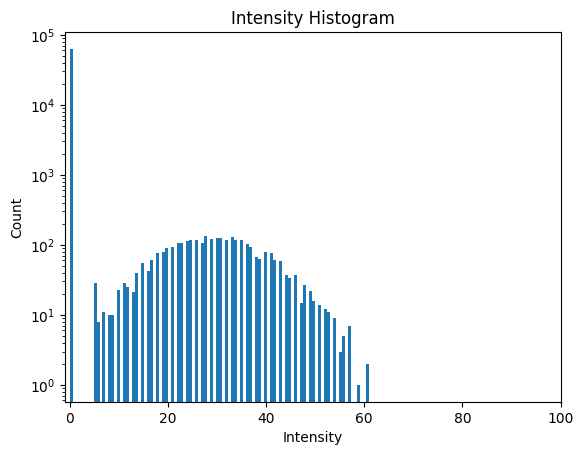

In [207]:
plt.hist(low_dose_bimodal[0,0,:,:].ravel(), bins=100)
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.title("Intensity Histogram")
plt.xlim(-1,100)
#plt.ylim(0,100)
plt.yscale("log")
plt.show()

In [ ]:
ground_truth = plt.figure(figsize=(5,5))
plt.imshow(datacube[0,0,:,:].hist, vmax = 10, cmap='gray')
ground_truth.show()

C:\Users\cancellara\AppData\Local\Temp\ipykernel_18444\1846831514.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ground_truth.show()
C:\Users\cancellara\AppData\Local\Temp\ipykernel_18444\1846831514.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  noisy.show()
C:\Users\cancellara\AppData\Local\Temp\ipykernel_18444\1846831514.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  difference.show()


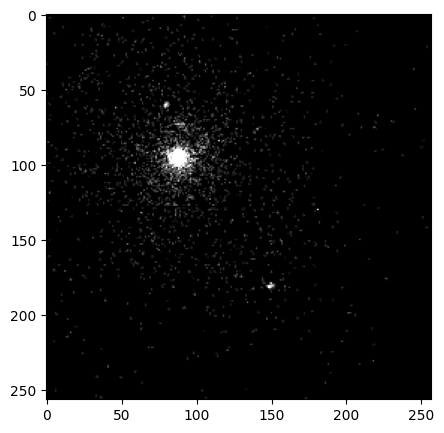

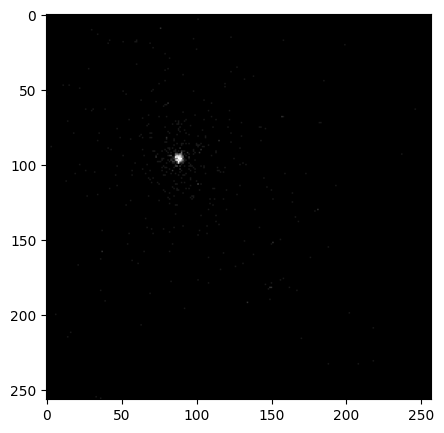

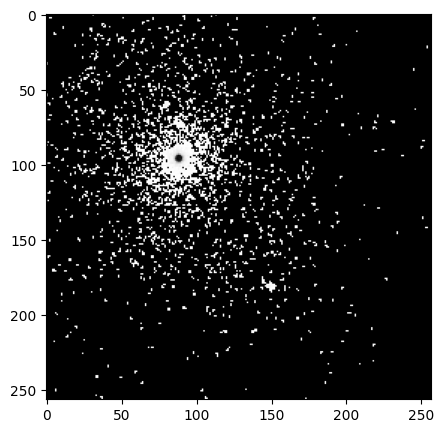

In [118]:
ground_truth = plt.figure(figsize=(5,5))
plt.imshow(datacube[0,0,:,:], vmax = 10, cmap='gray')
ground_truth.show()

noisy = plt.figure(figsize=(5,5))
plt.imshow(low_dose_dc[0,0,:,:], vmax = 10, cmap='gray')
noisy.show()

difference = plt.figure(figsize=(5,5))
plt.imshow(low_dose_dc[0,0,:,:] - datacube[0,0,:,:], cmap='gray') #vmax=10
difference.show()

C:\Users\cancellara\AppData\Local\Temp\ipykernel_18444\892118669.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  noisy.show()


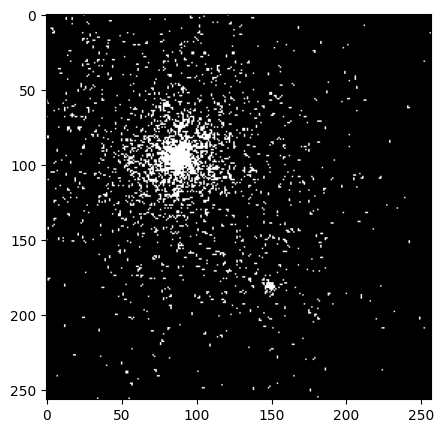

In [208]:
noisy = plt.figure(figsize=(5,5))
plt.imshow(low_dose_bimodal[1,0,:,:], vmax = 1, cmap='gray')
noisy.show()

### PART 3: Compare original and noisy

In [80]:
noisy_present = True

In [ ]:
#centered = center_datacube(datacube, method='xcorr', verbose=True)

In [57]:
# 32Gb memory requirement, only run on hpc

# FASTEST - Simple CoM
#centered = fast_center_datacube(datacube, method='com', verbose=True)

# Or FAST + ROBUST - FFT cross-correlation with 2× downsampling
#centered = fast_center_datacube(datacube, method='fft', downsample=2, verbose=True)

In [ ]:
## LOWEST MEMORY (~8 GB for 4 GB datacube)
#centered = memory_efficient_center(datacube, method='com', verbose=True)

# BALANCED (~12 GB with downsample=4)
centered = memory_efficient_center(datacube, method='fft', downsample=4, chunk_size=10, verbose=True)
#
## ULTRA-LOW (~6 GB)
#centered = memory_efficient_center(datacube, method='two_pass', verbose=True)

In [199]:
#datacube = centered
noisy_dc = low_dose_bimodal

In [200]:
#Calculate mean and max diffraction patterns in Q
dp_mean = datacube.get_dp_mean()
dp_max = datacube.get_dp_max()
if noisy_present == True:
    dp_mean_noisy = noisy_dc.get_dp_mean()
    dp_max_noisy = noisy_dc.get_dp_max()

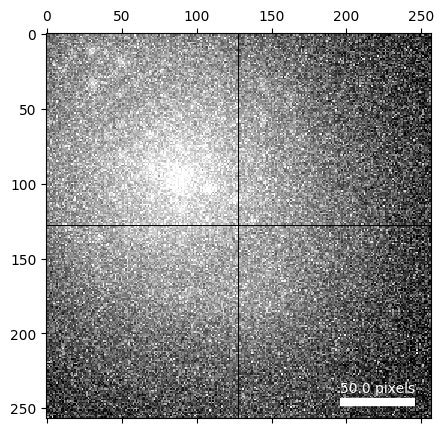

In [210]:
show(dp_max_noisy)

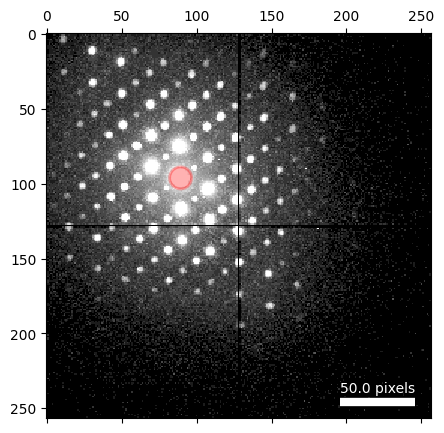

Estimated probe radius = 7.35 pixels


In [119]:
# Find the center and probe radius
# Get the probe position and size. Note that if the datacube is overexposed we need to use a reference datacube
probe_semiangle, probe_qx0, probe_qy0 = datacube.get_probe_size(dp_mean.data,thresh_lower=0.0001,thresh_upper=0.05,N=50)

# Overlay the computed probe over the maximum diffraction pattern
show(dp_max,scaling='log',circle={'center':(probe_qx0, probe_qy0),'R':probe_semiangle,'alpha':0.3,'fill':True})

# Print the estimated probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

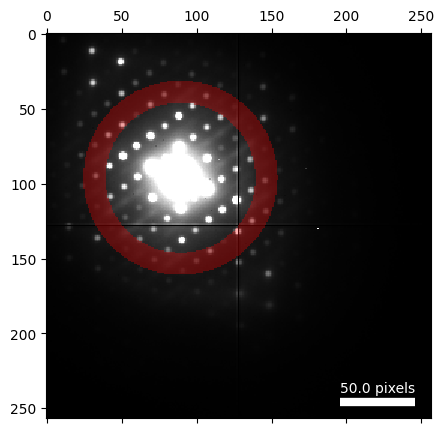

In [120]:
# Position the virtual annular detector. Radii can be changed to visualize different features
#probe_semiangle = 8.86
center = probe_qx0, probe_qy0
r_inner = probe_semiangle * 6.8
r_outer = probe_semiangle * 8.8
radii = r_inner,r_outer

# overlay selected detector position over mean dp
datacube.position_detector(mode='annular',geometry=(center,radii))

In [121]:
# Capture the virtual ADF and BF to select reference and analysis ROIs
datacube.get_virtual_image(mode='annulus',geometry=(center,radii),name='annular_dark_field')
datacube.get_virtual_image(mode='circle',geometry=(center,probe_semiangle),name='bright_field',)
if noisy_present == True:
    noisy_dc.get_virtual_image(mode='annulus',geometry=(center,radii),name='annular_dark_field')
    noisy_dc.get_virtual_image(mode='circle',geometry=(center,probe_semiangle),name='bright_field',)


100%|█████████████████████████████████████████████████████████████████████████| 65025/65025 [00:04<00:00, 13512.28it/s]


Original: 


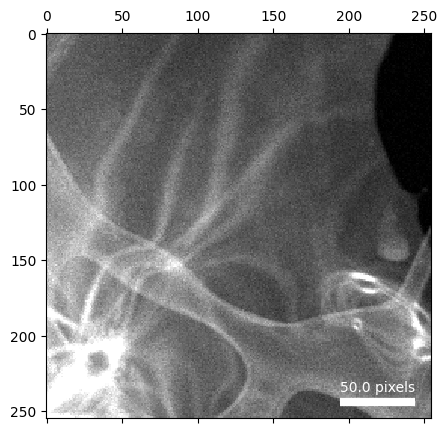

Noisy: 


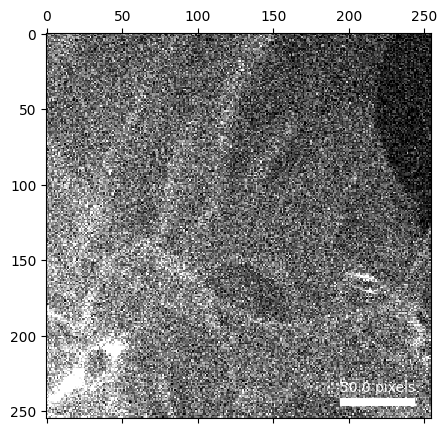

In [122]:
print("Original: ")
show(datacube.tree('annular_dark_field'))
if noisy_present == True:
    print("Noisy: ")
    show(noisy_dc.tree('annular_dark_field'))
#plt.imsave(r"PATH.tiff",datacube.tree('annular_dark_field').data, cmap='gray')

Original: 


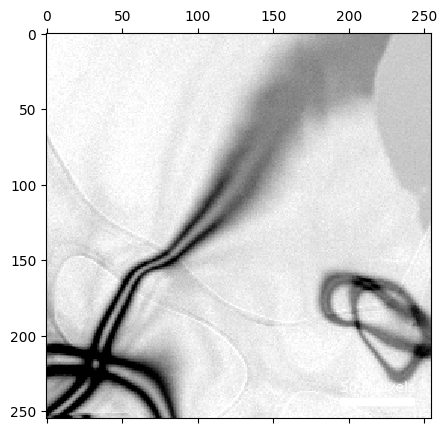

Noisy: 


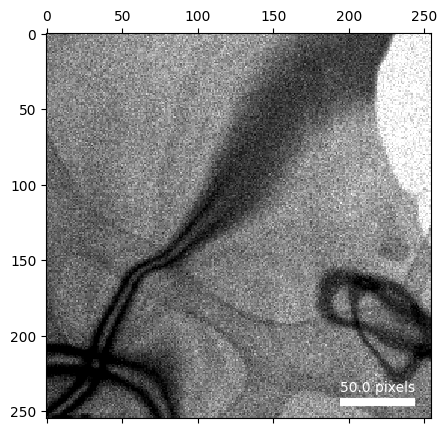

In [124]:
print("Original: ")
show(datacube.tree('bright_field'))
if noisy_present == True:
    print("Noisy: ")
    show(noisy_dc.tree('bright_field'))

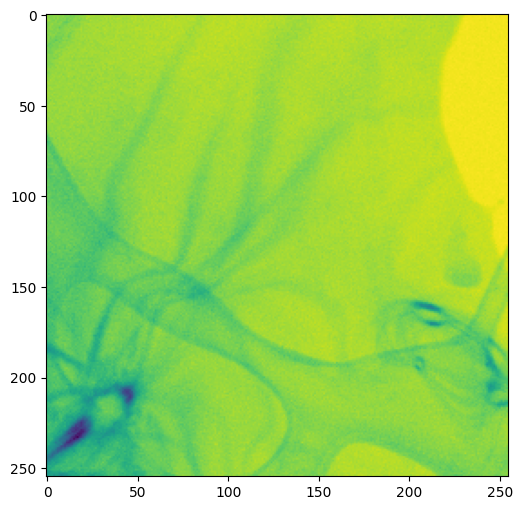

In [125]:
if noisy_present == True:
    bf_difference = noisy_dc.tree('bright_field').data - datacube.tree('bright_field').data
    adf_difference = noisy_dc.tree('annular_dark_field').data - datacube.tree('annular_dark_field').data
    plt.figure(figsize=(6,6))
    plt.imshow(adf_difference)

### Find Bragg disks

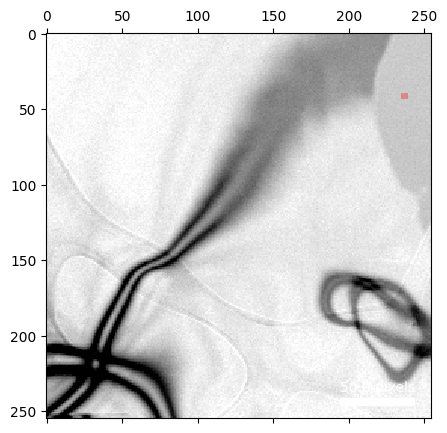

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 43.47it/s]


In [444]:
mask_q = np.zeros(datacube.Rshape,dtype=bool)
mask_q[40:44,235:240] = 1
show(
    datacube.tree('bright_field'),
    mask = ~mask_q,
    mask_alpha = 0.667,
    mask_color = 'r'
)
#probe_dp_mean = datacube.get_dp_mean()
#probe_semiangle, probe_qx, probe_qy = datacube.get_probe_size(plot=True)
probe = datacube.get_vacuum_probe(ROI=mask_q)
alpha_pr,qx0_pr,qy0_pr = py4DSTEM.process.calibration.get_probe_size( probe.probe )

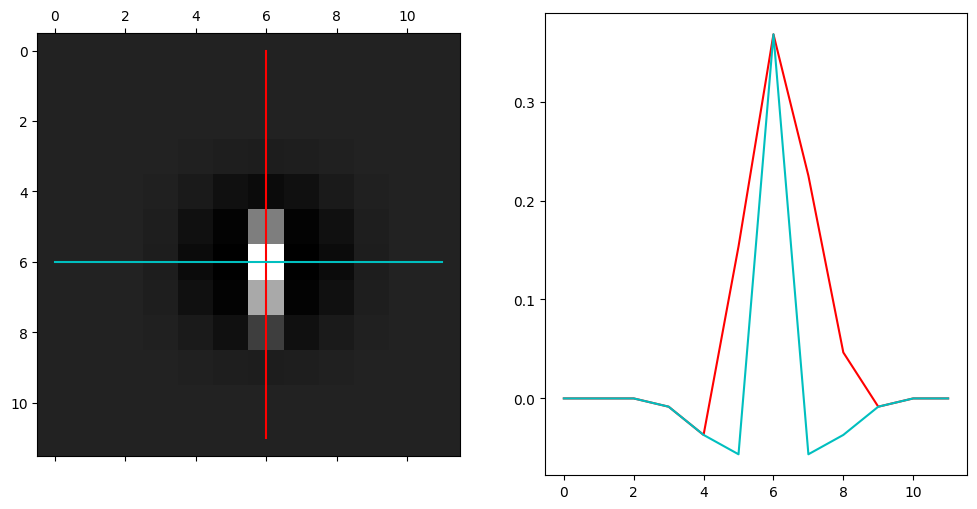

In [452]:
# prepare the probe kernel
#probe.get_kernel(mode='sigmoid',origin=center, radii=(0.1*probe_semiangle,3*probe_semiangle))   # the inner and outer radii of the 'trench'
probe.get_kernel(
    mode='sigmoid',
    origin = (qx0_pr,qy0_pr),
    radii=(1*alpha_pr,4.5*alpha_pr)   # the inner and outer radii of the 'trench'
)

py4DSTEM.visualize.show_kernel(
    probe.kernel,
    R = 6,
    L = 6,
    W = 1
)

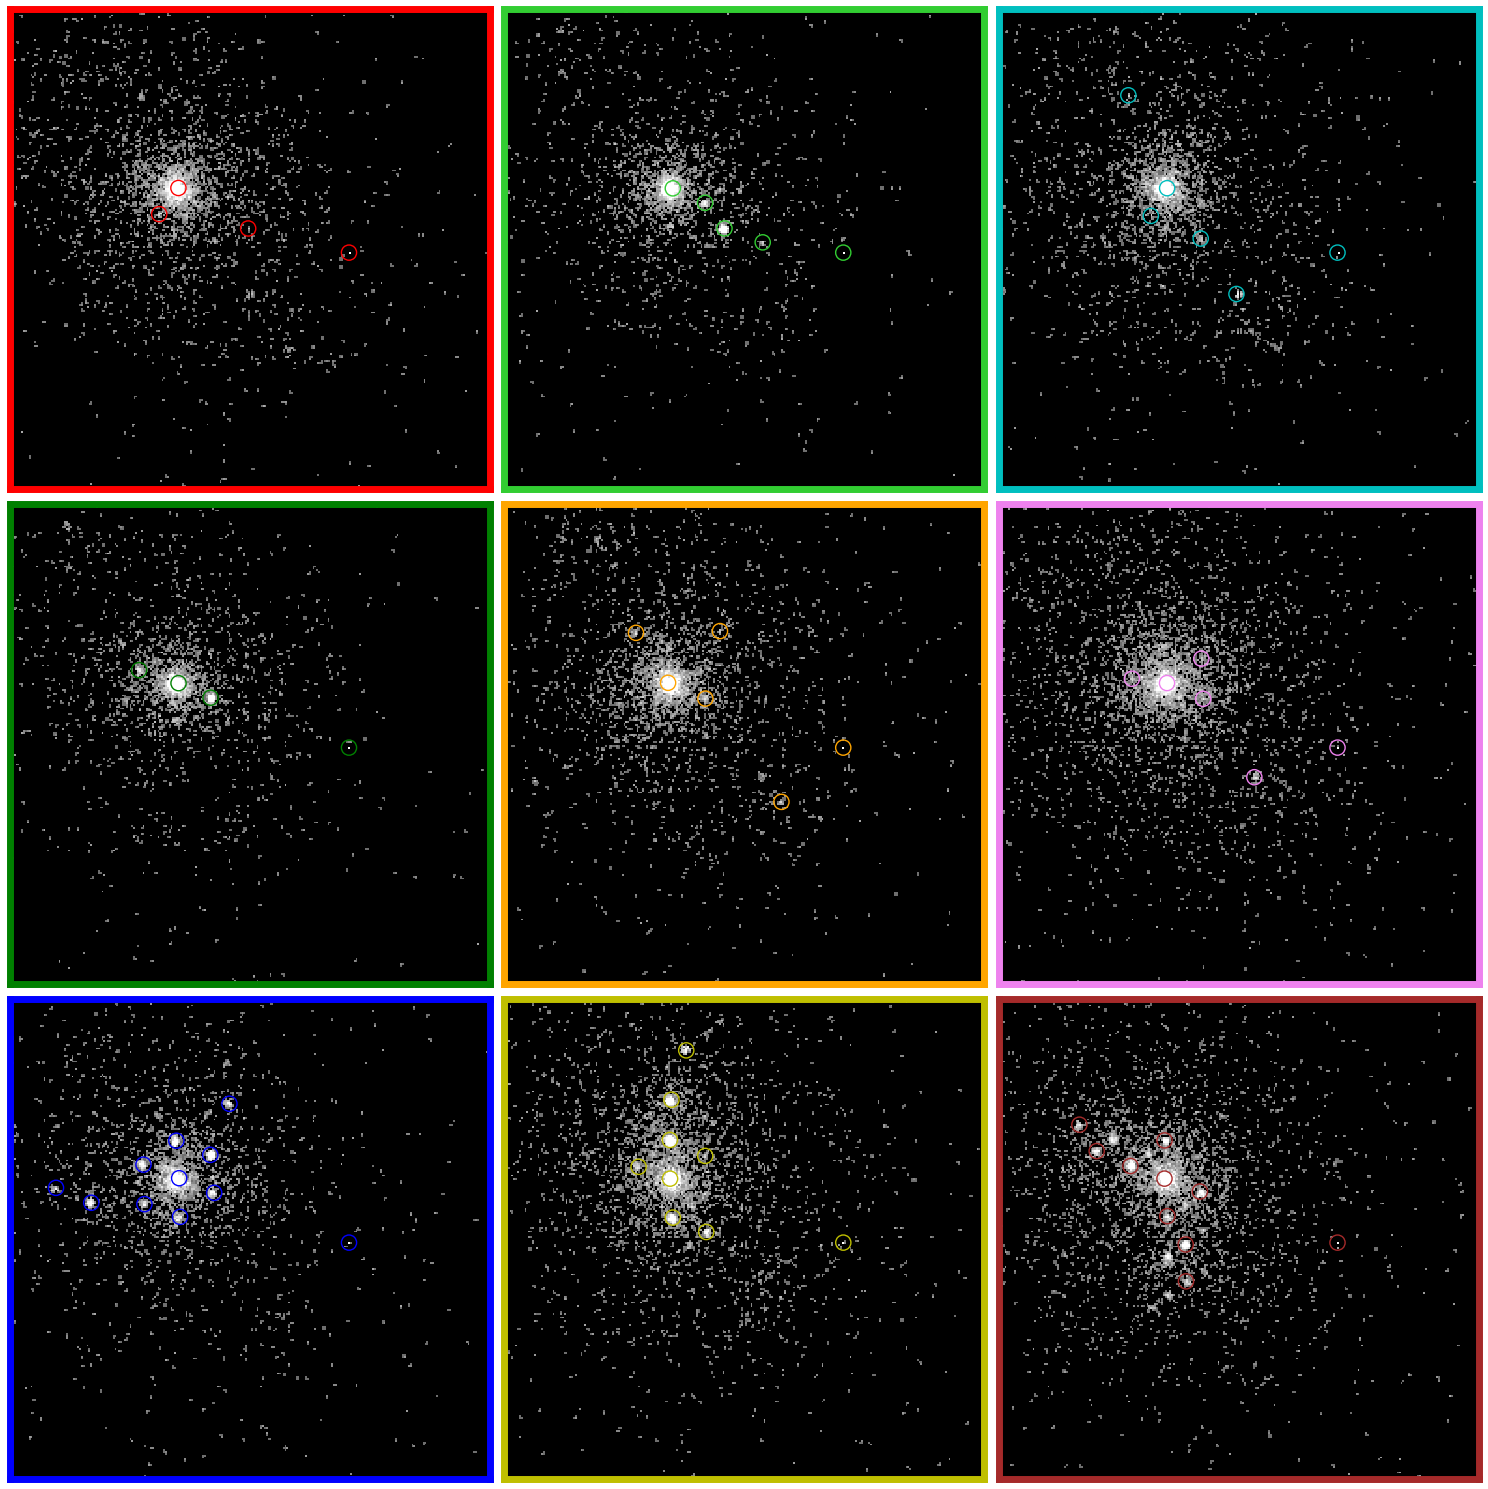

In [454]:
# Choose disk detection parameters
# set parameters
rxs = 0,18,30,40,80,100,160,200,240
rys = 17,110,8,110,10,10,120,12,40
colors=['r','limegreen','c','g','orange', 'violet', 'b', 'y', 'brown']

detect_params = {
    'minAbsoluteIntensity': 3,   #200 # intensity threshold
    'minRelativeIntensity': 0.0001,   # int. thresh. relative to brightest disk in each pattern
    'minPeakSpacing': 15,         # if two peaks are closer than this (in pixels), remove the dimmer peak
    'edgeBoundary': 20,           # remove peaks within this distance of the edge of the diffraction pattern
    'sigma': 0,                  # gaussian blur size to apply to cross correlation before finding maxima
    'maxNumPeaks': 150,          # maximum number of peaks to return, in order of intensity
    'subpixel' : 'multicorr',         # subpixel resolution method
    'corrPower': 0.99,            # if <1.0, performs a hybrid cross/phase correlation. More sensitive to edges and to noise
    'CUDA': True,              # if a GPU is configured and cuda dependencies are installed, speeds up calculation 
    'CUDA_batched': True,
}

# method to find disks for selected patterns
disks_selected = datacube.find_Bragg_disks(data=(rxs,rys),template=probe.kernel,**detect_params,)

# show
py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube[rxs[i],rys[i],:,:],
    H=3, 
    W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=0,
    vmax=15.874,
    scaling='power',
    power=0.3,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 120,
)

In [455]:
#We make a copy of the original datacube, as the following operations will rewrite it
#datacube_backup = datacube.copy()
datacube = datacube_backup.copy()

In [456]:
braggpeaks = datacube.find_Bragg_disks(template=probe.kernel,**detect_params,)

Using 7 batches of 9365 patterns each...


Finding Bragg disks in batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [10:59<00:00, 94.25s/batch]


Analyzed 65025 diffraction patterns in 0.0h 10.0m 59.90s
(avg. speed 98.5379 patterns per second)


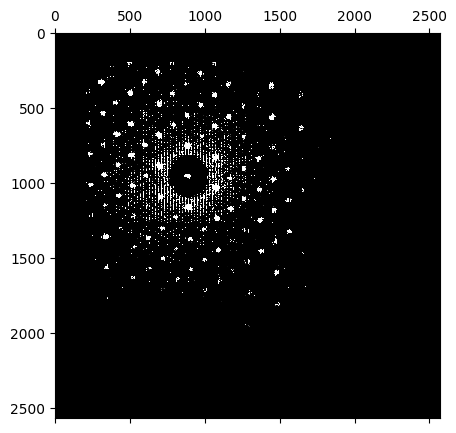

In [457]:
show(braggpeaks.histogram(mode='raw', sampling = 10))

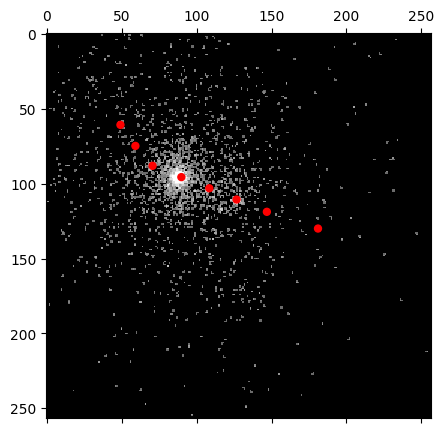

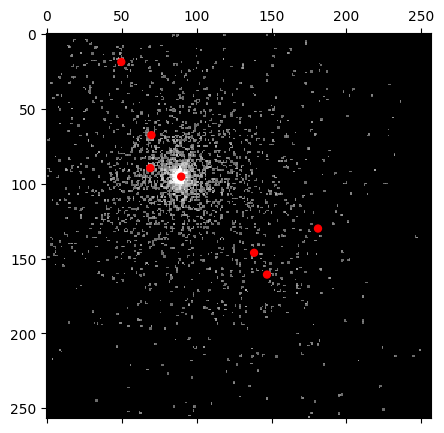

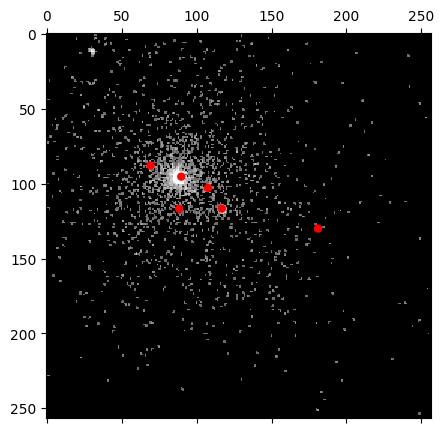

In [458]:
# Let's confirm that the raw vectors represent the positions of
# detected bragg disks in a sample diffraction pattern

dp = datacube[100,100]
v = braggpeaks.raw[100,100]
show(dp, points={'x':v.qx,'y' : v.qy,}, intensity_range='absolute', vmin=0, vmax=18, scaling='power', power=0.3,)

dp1 = datacube[40,40]
v1 = braggpeaks.raw[40,40]
show(dp1, points={'x':v1.qx,'y':v1.qy,}, intensity_range='absolute', vmin=0, vmax=18, scaling='power', power=0.3,)

dp2 = datacube[40,90]
v2 = braggpeaks.raw[40,90]
show(dp2, points={'x':v2.qx,'y':v2.qy,}, intensity_range='absolute', vmin=0, vmax=18, scaling='power', power=0.3,)

In [209]:
# Force uint8 and matching chunks
save_data = hs.signals.Signal2D(low_dose_bimodal.data.astype(np.uint8))
save_data.save(r'Leeds Molecular crystals\Noisy_datacubes\p-terphenyl_20_low_dose-bimodal.hdf5', file_format='HSPY', overwrite=True, compression='gzip', compression_opts=4, chunks=(2, 4, 257, 257))

In [411]:
#s.save('save_test_matched.hdf5', file_format='HSPY', overwrite=True, compression='gzip', compression_opts=4, chunks=(2, 4, 257, 257))

In [394]:
# Check original
print("Original dtype:", s.data.dtype)
print("Original size (GB):", s.data.nbytes / 1e9)

# Check your processed version
print("Processed dtype:", save_test.data.dtype)
print("Processed size (GB):", save_test.data.nbytes / 1e9)

Original dtype: uint8
Original size (GB): 4.294836225
Processed dtype: uint8
Processed size (GB): 4.294836225


In [398]:
def inspect_hdf5_detailed(filename):
    """Detailed inspection of HDF5 file structure"""
    with h5py.File(filename, 'r') as f:
        def print_details(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"\n{name}:")
                print(f"  Shape: {obj.shape}")
                print(f"  Dtype: {obj.dtype}")
                print(f"  Compression: {obj.compression}")
                print(f"  Compression opts: {obj.compression_opts}")
                print(f"  Chunks: {obj.chunks}")
                print(f"  Size on disk: {obj.nbytes/1e9:.3f} GB")
        f.visititems(print_details)

In [407]:
print("=== ORIGINAL FILE ===")
original_path=r'C:\Users\cancellara\3_Hackaton2025\Leeds Molecular crystals\4D-STEM data for p-terphenyl\Mg31258\20220323_160424_data_binned2.hdf5'
inspect_hdf5_detailed(original_path)

=== ORIGINAL FILE ===

Experiments/__unnamed__/data:
  Shape: (255, 255, 257, 257)
  Dtype: uint8
  Compression: gzip
  Compression opts: 4
  Chunks: (2, 4, 257, 257)
  Size on disk: 4.295 GB

Experiments/__unnamed__/metadata/Signal/_list_flyback_times:
  Shape: (4,)
  Dtype: float64
  Compression: gzip
  Compression opts: 4
  Chunks: (4,)
  Size on disk: 0.000 GB


In [405]:
print("\n=== NEW FILE ===")
inspect_hdf5_detailed("test_uint8.hdf5")


=== NEW FILE ===

Experiments/__unnamed__/data:
  Shape: (255, 255, 257, 257)
  Dtype: uint8
  Compression: gzip
  Compression opts: 4
  Chunks: (2, 4, 257, 257)
  Size on disk: 4.295 GB


In [412]:
# Check actual file sizes
original_size = os.path.getsize(original_path) / 1e6  # MB
new_size = os.path.getsize('save_test_matched.hdf5') / 1e6  # MB

print(f"Original file: {original_size:.1f} MB")
print(f"New file: {new_size:.1f} MB")
print(f"Ratio: {new_size/original_size:.2f}x")

# Check compression ratio for the data itself
original_uncompressed = s.data.nbytes / 1e6  # MB
new_uncompressed = noisy_dc.data.nbytes / 1e6  # MB

print(f"\nUncompressed sizes:")
print(f"Original: {original_uncompressed:.1f} MB")
print(f"New: {new_uncompressed:.1f} MB")

print(f"\nCompression ratios:")
print(f"Original: {original_uncompressed/original_size:.2f}x")
print(f"New: {new_uncompressed/new_size:.2f}x")

Original file: 333.1 MB
New file: 333.1 MB
Ratio: 1.00x

Uncompressed sizes:
Original: 4294.8 MB
New: 4294.8 MB

Compression ratios:
Original: 12.89x
New: 12.89x


In [415]:
# Quick sanity check
print(f"Data changed: {not np.array_equal(s.data, noisy_dc.data)}")
print(f"Mean difference: {np.mean(np.abs(s.data.astype(float) - noisy_dc.data.astype(float))):.3f}")
print(f"Max difference: {np.max(np.abs(s.data.astype(float) - noisy_dc.data.astype(float)))}")

Data changed: True
Mean difference: 1.959
Max difference: 33.0
